In [1]:
import warnings
warnings.filterwarnings('ignore')

# Classfication

Input vector $\mathbb{x}=(x_1,...,x_m)$와, input vertor가 속할 수 있는 category list $\mathbb{y}=\{1,...,k\}$가 주어졌다고 가정하자. Classification은 input data $\mathbb{x}$에 대해서, $\mathbb{x}$가 $k$개의 카테고리 중에서 어디에 속하는지 결정하고 대응시켜주는 task이다. Leaning 알고리즘은 $\mathbb{x}$와 $\mathbb{x}$가 대응되는 카테고리를 mapping 하는 함수를 학습한다. 함수는 다음과 같이 표현된다. 
$$f:\mathbb{R}^n \to \{1,...,k\}$$

# Classifier의 종류
- Naive Bayesian Classifier
- Logistic Regression
- Decsion Tree
- Ensemble model
 - Bagging
 - Random forest 
 - Gradient Boosting
 - Adaboost
 - XGBoost
- SVM
- Perceptron
- Deep Neural Network

# MNIST와 scikit-learn을 활용한 binary classification tutorial

## 1. MNIST

- 70,000개의 숫자 이미지
- 각 이미지에 어떤 숫자가 대응되는지 labeling (0, ... ,9 까지의 정수)
- 새로운 분류 알고리즘이 나올 때마다 MNIST 데이터 셋에서 얼마나 잘 작동하는지를 테스트
- 머신러닝 알고리즘 영역의 hello world 데이터 셋

<img src='./images/mnist.png', width="400" height="400">

### 1.1 Keras를 이용하여 데이터 셋 불러오기

In [2]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


In [3]:
x_train.shape

(60000, 28, 28)

In [4]:
x_test.shape

(10000, 28, 28)

- 이미지는 총 70,000개 (train : 60,000개 / test : 10,000개)
- Feature의 갯수(pixel의 갯수)는 784개 ($28 \times 28$)이며, 각 entry는 0~255까지의 픽셀 강도를 나타냄

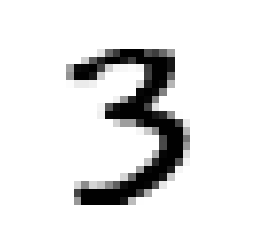

In [5]:
# 이미지 데이터를 plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

digit = x_train[10000]
plt.imshow(digit, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [6]:
# 그 이미지의 label
y_train[10000]

3

> Tip : **Training set을 섞어서 모든 교차 검증 폴드가 비슷하게 만들어야 한다. (즉, 특정 폴드에서, 특정 숫자가 누락되면 안된다.)**
     - 데이터셋을 랜덤하게 섞는다.
     - 특정 카테고리에 속하는 데이터가 연속적으로 나오지 않도록 한다. (모델이 순서를 학습할 수 있다.)
     - 단, 시계열 데이터는 섞으면 안된다.

## 2. Binary classification

문제를 단순하게 하기 위해서,
 - 숫자 5이다.
 - 숫자 5가 아니다.
 
로 분류

In [7]:
y_train_5 = (y_train == 5)  # 5는 True, 그 외는 False
y_test_5 = (y_test == 5)  # 5는 True, 그 외는 False

In [8]:
y_train_5[:5]

array([ True, False, False, False, False])

In [9]:
print(x_train.shape)
print(y_train_5.shape)

(60000, 28, 28)
(60000,)


### 2.1 SGDClassifier (Stochastic Gradient Descent Classifier)
확률적 경사 하강법 분류기 : 하나의 독립된 훈련 샘플을 처리하고 모델을 업데이트

In [10]:
# 확률적 경사 하강법 분류기를 사용하기 위해서는 input shape이 2 dim 이어야 한다.
import numpy as np

x_train_2d = np.reshape(x_train, (-1, 784))
x_test_2d = np.reshape(x_test, (-1, 784))

In [11]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(max_iter=5, random_state=42)
# 훈련
sgd.fit(x_train_2d, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [12]:
# 결과 check
pred = sgd.predict([x_train_2d[10]])
print('Prediction: ', pred)
print('Actual: ', y_train_5[10])

Prediction:  [False]
Actual:  False


## 3. Performance 측정

In [13]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 5)

### 3-1. 교차 검증을 사용한 정확도 측정

모델이 학습되는 동안 overfitting을 확인 및 성능을 평가하기 위하여, 즉 모델의 학습 정도를 확인하기 위하여 validation set이 필요하다.

Validation data를 생성하기 위해서, training data의 부족 현상이 발생할 수 있다. 이런 경우는 학습이 충분히 제대로 이루어지지 않는다. Training data가 부족하다면, validation set을 어떻게 확보할 수 있을까?
- Multi($K$)-fold cross validation : Dataset을 $K$개의 부분 집합으로 나눈다. 하나의 부분집합을 validation set으로 사용하고, 나머지 $K-1$개의 부분집합을 training set으로 활용한다. 이 과정을 $K$번 반복한다. $K$번의 validation check가 가능하고 그 중 가장 작은 validation error를 보이는 모델을 선택한다. 물론 각 과정에서 training set과 validation set은 mutually exclusive하다. 학습 과정중에서 $K$개의 다양한 모델을 만들면서 학습하기 때문에 시간의 trade off가 발생한다.
- Leave-one-out cross-validation : Dataset의 크기가 $n$ 이라면 1개의 data sample을 validation data로 사용하고 $n-1$개의 데이터를 training set으로 사용한다. $n$번 validation을 수행한 후, error를 계산한다.

> Customizing이 가능한 코드 (sklearn의 cross val score와 동일한 일을 수행한다.)

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# 데이터의 각 class 별 비율을, fold에서 맞추어준다.
skfolds = StratifiedKFold(n_splits=3, random_state=42)

In [15]:
# 총 3개의 
(cv_train_1, cv_test_1), (cv_train_2, cv_test_2), (cv_train_3, cv_test_3) \
    = list(skfolds.split(x_train_2d, y_train_5))

- 첫 번째 cross validation set을 위한 index 들

In [16]:
# Train set
print('첫 번째 train set :', len(cv_train_1))
cv_train_1

첫 번째 train set : 40000


array([19964, 19965, 19966, ..., 59997, 59998, 59999])

In [17]:
# Test set
print('첫 번째 test set :', len(cv_test_1))
cv_test_1

첫 번째 test set : 20000


array([    0,     1,     2, ..., 20331, 20342, 20359])

(array([2036., 2036., 2036., 2036., 2036., 2036., 2036., 2036., 2036.,
        1676.]),
 array([    0. ,  2035.9,  4071.8,  6107.7,  8143.6, 10179.5, 12215.4,
        14251.3, 16287.2, 18323.1, 20359. ]),
 <a list of 10 Patch objects>)

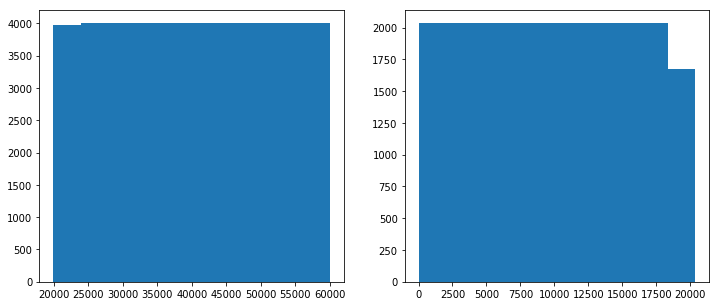

In [18]:
plt.subplot(1,2,1)
plt.hist(cv_train_1)
plt.subplot(1,2,2)
plt.hist(cv_test_1)

- 두 번째 cross validation set을 위한 index 들

In [19]:
# Train set
print('두 번째 train set :', len(cv_train_2))
cv_train_2

두 번째 train set : 40000


array([    0,     1,     2, ..., 59997, 59998, 59999])

In [20]:
# Test set
print('두 번째 train set :', len(cv_test_2))
cv_test_2

두 번째 train set : 20000


array([19964, 19965, 19966, ..., 40088, 40125, 40127])

(array([1981., 2016., 2016., 2017., 2016., 2016., 2017., 2016., 2016.,
        1889.]),
 array([19964. , 21980.3, 23996.6, 26012.9, 28029.2, 30045.5, 32061.8,
        34078.1, 36094.4, 38110.7, 40127. ]),
 <a list of 10 Patch objects>)

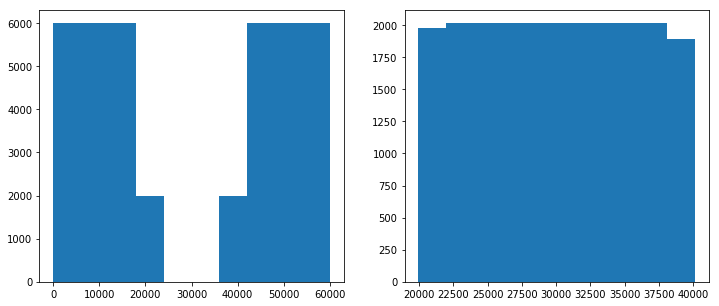

In [21]:
plt.subplot(1,2,1)
plt.hist(cv_train_2)
plt.subplot(1,2,2)
plt.hist(cv_test_2)

- 세 번째 cross validation set을 위한 index 들

In [22]:
# Train set
print('세 번째 train set :', len(cv_train_3))
cv_train_3

세 번째 train set : 40000


array([    0,     1,     2, ..., 40088, 40125, 40127])

In [23]:
# Test set
print('세 번째 test set :', len(cv_test_3))
cv_test_3

세 번째 test set : 20000


array([39988, 39989, 39990, ..., 59997, 59998, 59999])

(array([1990., 2001., 2001., 2001., 2001., 2001., 2001., 2001., 2001.,
        2002.]),
 array([39988. , 41989.1, 43990.2, 45991.3, 47992.4, 49993.5, 51994.6,
        53995.7, 55996.8, 57997.9, 59999. ]),
 <a list of 10 Patch objects>)

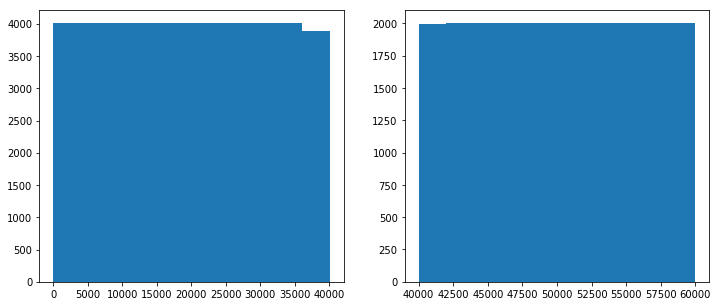

In [24]:
plt.subplot(1,2,1)
plt.hist(cv_train_3)
plt.subplot(1,2,2)
plt.hist(cv_test_3)

In [25]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# 데이터의 각 class 별 비율을, fold에서 맞추어준다.
skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(x_train_2d, y_train_5):
    clone_sgd = clone(sgd)
    x_train_folds = x_train_2d[train_index]
    y_train_folds = y_train_5[train_index]
    x_test_folds = x_train_2d[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_sgd.fit(x_train_folds, y_train_folds)
    y_pred = clone_sgd.predict(x_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.9532
0.95125
0.9625


> `cross_val_score`를 이용한다.

In [26]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd, x_train_2d, y_train_5, cv=3, scoring='accuracy')

array([0.9532 , 0.95125, 0.9625 ])

왜 이렇게 성능이 높을까?

In [27]:
from collections import Counter
print('Training set:', Counter(y_train_5))
print('Test set:', Counter(y_test_5))

Training set: Counter({False: 54579, True: 5421})
Test set: Counter({False: 9108, True: 892})


이렇게 **불균형한 데이터를 다룰때**는 분류기의 성능 지표로 accuracy가 과연 좋을까?

### 3-2 오차 행렬 (Confusion matrix)
 - 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것

In [28]:
from sklearn.model_selection import cross_val_predict

# SGDClassifier 내부적으로 decision_function을 사용하여, 
# 각 샘플에 대한 결정함수 결과값이 나오고 그것을 이용하여 True, False인지 구분합니다. (hinge loss이므로, predict_prob를 사용하지 않습니다.)
y_train_pred = cross_val_predict(sgd, x_train_2d, y_train_5, cv=3)

In [29]:
x_train_2d.shape

(60000, 784)

`cross_val_predict`: K-fold 교차 검증을 수행하지만, 평가점수를 반환하지 않고, 예측값을 반환한다.

In [30]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[52992,  1587],
       [ 1074,  4347]])

- confusion matrix의 row : 실제 클래스
- confusion matrix의 column : 예측한 클래스

| Confusion mtx | Prediction(0, $H_0$)| Prediction(1, $H_1$) |
| :----------------------: |:-------------------:| :--------------------: |
| Actual class(0) | True Negative | False Positive |
| Actual class(1) | False Negative | True Positive |

우리의 예제를 살펴보면,

| Confusion mtx | Prediction(0, $H_0$)| Prediction(1, $H_1$) |
| :----------------------: |:-------------------:| :--------------------: |
| Actual class(0) | 52992 | 1587 |
| Actual class(1) | 1074 | 4347 |

### 3-3 F1 score

#### Precision, 정밀도

- $\text{Precision}=\frac{TP}{TP+FP}$

- 분류기가 "1"이라고 예측한 샘플 중에서, 실제 값이 "1"인 샘플의 비율

#### Recall, 재현율 (또는 Sensitivity, 민감도, True Positive Rate, 진짜 양성 비율)
 - $\text{Recall}=\frac{TP}{TP+FN}$
 - 실제 값이 "1"인 샘플 중에서, 분류기가 "1"이라고 예측한 비율

In [31]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.7325581395348837

5로 판별된 샘플중에서 73%로만 정확

In [32]:
recall_score(y_train_5, y_train_pred)

0.8018815716657444

전체 5에서 80%만 감지

#### $F_1$ socre
- Precision과 Recall의 조화 평균(harmonic mean)
- $F_1=\frac{2}{\frac{1}{\text{Precision}}+\frac{1}{\text{Recall}}}=2\times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}=\frac{TP}{TP+\frac{FN+FP}{2}}$

In [33]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.765653896961691

과연 $F_1$ score가 높은 것이 항상 좋을까?
 - 어린아이에게 안전한 동영상을 걸러내는 분류기를 훈련
  - 좋은 동영상의 Recall은 낮아도, 좋은 동영상의 Precision이 높도록
 - 카메라를 통해 좀도둑을 잡아내는 분류기
  - 좀도둑의 Precision은 낮아도, 좀도둑의 recall은 높도록

### 3-4 Precision/Recall trade off

Sklearn의 모델들에서 결과를 얻는 방법
 - predict : prediction의 값을 얻습니다. 회귀이면 실수 결과값을 얻습니다. 분류이면 카테고리 결과값을 얻습니다.
 - predict_prob : 예측 할 때 사용하는 값이 0과 1사이의 확률값을 따르는 경우 사용할 수 있습니다.
 - decision_function : 예측 할 때 사용하는 값이 실수일 때(예를 들어, 사용하는 loss function이 hinge loss 인 경우) 사용할 수 있습니다.

SGDClassifier가 분류를 결정하는 방법 : `decision_function` (결정 함수)를 사용하여 각 샘플의 점수를 계산
 - 샘플의 점수 $\geq$ 임계값(threshold) : 양성 클래스에 할당
 - 샘플의 점수 < 임계값(threshold) : 음성 클래스에 할당

In [34]:
# Sample을 하나 추출한다.
print(x_train_2d[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255
 247 127   0   0   0   0   0   0   0   0   0   0   0   0  30  36  94 154
 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0   0   0
   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82
  82  56  39   0   0   0   0   0   0   0   0   0   0   0   0  18 219 253
 253 253 253 253 198 182 247 241   0   0   0   0   

In [35]:
# 결정 함수에 사용된 점수를 확인
y_scores = sgd.decision_function([x_train_2d[0]])
y_scores

array([-45148.19955869])

사이킷런의 `cross_val_predict`는 이미 내부에서 임계값을 사용하여, 임계값보다 크면 True, 작으면 False를 반환하게 합니다(binary의 경우). 그리고 사이킷런에서는 임계값을 직접 설정할 수 없습니다. 즉 y_score를 `decision_function`을 통해 구했다면, 우리가 직접 임계값을 설정해주고, 임계값에 따른 분류결과를 리턴하는 코드를 구현해야 합니다.

In [36]:
print('현재 분류기의 결과값 :', y_train_pred[0])
print('실제 라벨의 값 :', y_test_5[0])

현재 분류기의 결과값 : True
실제 라벨의 값 : False


결과는 보는바와 같이 다릅니다. 우리는 이 경우 *y_train_pred*를 구하는 식을 수정할 수 있습니다.

In [37]:
def customized_pred_results(result_of_decision_function, threshold):
    return result_of_decision_function > threshold

In [38]:
customized_pred_results(y_scores[0], 0)

False

이렇게 임계값을 조절하면 예측의 결과를 조절할 수 있습니다.

하지만 만약에 임계값을 변경하게 되면 예측값이 변화하게 되어, precision / recall이 변하게 됩니다. 따라서 적절한 임계값을 정하는것이 중요합니다.

<img src='./images/precison_recall.png', width="1000" height="600">

`cross_val_predict`를 활용하여 precision recall을 조정해보겠습니다.

`cross_val_predict`은 cross validation을 이용하여 결과를 반환해주는 함수입니다. 단, 그 결과는 *method*에 따라 달라집니다.

In [39]:
y_scores = cross_val_predict(sgd, x_train_2d, y_train_5, cv=3, method='decision_function') 

In [40]:
y_scores[:10]

array([ 130454.39322866, -292310.89416081, -851504.62149277,
       -463884.18557022, -419318.98872844, -362596.81598131,
       -376116.98274832, -524189.31146637,  -39326.60070662,
       -219343.91422559])

In [41]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [42]:
# Threshold 리스트를 반환합니다.
print('Threshold의 길이 :', len(thresholds))
thresholds[:10]

Threshold의 길이 : 59664


array([-1689990.81265398, -1689514.10236993, -1689310.7182735 ,
       -1688408.63594058, -1688403.31253102, -1687979.50911516,
       -1687943.53878695, -1687314.58893952, -1686755.23292283,
       -1686271.09265537])

가장 낮은 임계치를 사용하여 5와 5가 아닌것의 분류를 예측하겠습니다. 임계치를 이렇게 사용하여 분류기를 만들게 되면 우리의 분류기는, 599663개를 5로 예측한 것입니다. 따라서 recall은 거의 1과 동일하게 되고 precision은 매우 작게 됩니다. 왜냐하면 우리의 분류기가 대부분의 숫자를 5라고 분류했기 때문입니다.

In [43]:
print(len(y_scores))
print(sum(y_scores > thresholds[0]))

60000
59663


In [44]:
print('precision :', precisions[0])
print('recall :', recalls[0])

precision : 0.09085880933226066
recall : 1.0


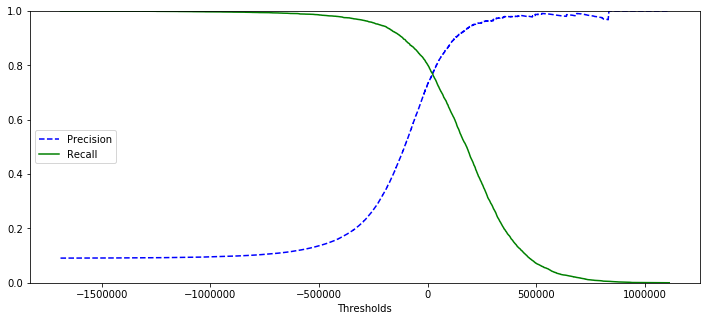

In [45]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Thresholds')
    plt.legend(loc='center left')
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Precision의 오른쪽 상단의 경우를 살펴보면, 울통불퉁한 것을 볼 수 있다. 임계치가 올라가도 때에 따라서 precision이 낮아질 수 있다. 왜냐면 분모도 함께 줄어들기 때문이다. 하지만, recall은 계속 평탄하게 간다. 그 이유는 분모는 고정되어 있고 분자만 줄어들기 때문이다.

In [46]:
mpl.rcParams['figure.figsize'] = (6, 6)

Text(0,0.5,'Precision')

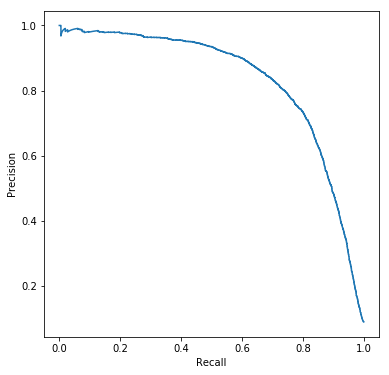

In [47]:
# Precision, recall graph를 그려보자.
plt.plot(recalls[:-1], precisions[:-1])
plt.xlabel('Recall')
plt.ylabel('Precision')

<font color='green'>Recall이 0.8일때 precision이 급격하게 줄어들기 때문에, precision을 중요시하는 모델을 생성하기 위해서는, 0.6~0.7 정도의 recall을 달성하는 theshold를 선택하는 것이 좋다. 이렇게 threshold를 customizing하기 위해서는 `predict()` 메소드를 호출하지 말고, `y_train_pred = (y_scores > new threshold)`처럼 한다.</font>

In [48]:
y_train_pred_new_thre = (y_scores > 70000)

In [49]:
precision_score(y_train_5, y_train_pred_new_thre)

0.8415374241402562

In [50]:
recall_score(y_train_5, y_train_pred_new_thre)

0.6906474820143885

### 3-5 ROC 곡선

- **Receiver Operating Characteristic(ROC)** 곡선은 binary classification에 널리 사용되는 도구
- **FPR에 대한 TPR의 곡선**
 - FPR : False Positive Rate, 거짓 양성 비율, 양성(1)로 잘못 분류된 음성(0)의 비율, $\frac{FP}{FP+TN}$, 1-specificity(TNR, 특이도). **즉 귀무가설이 참인데 귀무가설을 기각한 비율이다**.
 - TPR : True Positive Rate, Recall, Sensitivity, 진짜 양성 비율. **대립가설이 참이고, 귀무가설을 기각한 비율이다**.

In [51]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_train_5, y_scores)

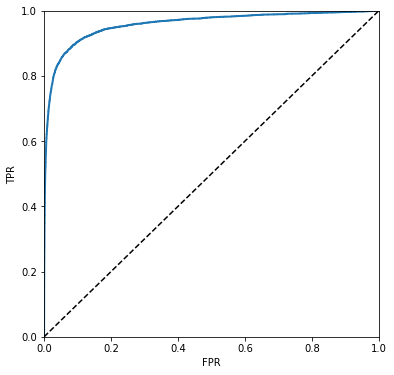

In [52]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('FPR')
    plt.ylabel('TPR')

plot_roc_curve(fpr, tpr, 'SGD')
plt.show()

Recall이 증가하면, 분류기가 양성으로 분류하는 경향이 커지기 때문에, FPR도 증가한다. 즉, Recall이 높을수록 분류기가 만드는 FPR이 증가한다. 좋은 분류기는 왼쪽 오른쪽 모서리에 가까워지며, 대각선의 점선과는 멀어져야한다.

점선은 랜덤 분류기의 ROC 곡선을 의미한다.

곡선 아래의 면적(AUC - area under curve)를 측정하면 분류기들을 비교할 수 있다. 완벽한 분류기는 ROC의 AUC가 1이고, 완전 랜덤 분류기는 0.5가 된다.

In [53]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9584692857783504

양성 클래스 sample이 드물거나, 거짓 음성보다 거짓 양성이 더 중요할 때는 Precision-Recall graph를 사용하고, 그렇지 않을 때는 ROC 곡선을 사용한다.

### 3-4. 다른 모델과의 성능 비교
- RandomforestClassifier vs SGDClassifier

In [54]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
# RandomForestClassifier에서는 decision_function을 사용하지 않고, predict_proba를 사용합니다.
y_prob_rf = cross_val_predict(rf, x_train_2d, y_train_5, cv=3, method='predict_proba')

/Users/kakao/.pyenv/versions/3.6.3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [55]:
# 확률값으로 나오기 때문에, 양성 클래스에 대한 확률을 점수로 사용함
y_scores_rf = y_prob_rf[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_train_5, y_scores_rf)

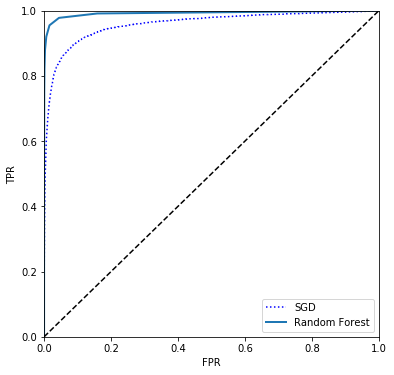

In [56]:
plt.plot(fpr, tpr, 'b:',label='SGD')
plot_roc_curve(fpr_rf, tpr_rf, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

#### ROC_AUC socre

In [57]:
roc_auc_score(y_train_5, y_scores_rf)

0.9920527492698306

#### Precision, Recall

In [58]:
precision_score(y_train_5, (y_scores_rf > 0.5))

0.986046511627907

In [59]:
recall_score(y_train_5, (y_scores_rf > 0.5))

0.8212506917542889